In [1]:
import random, glob, cv2, os
from matplotlib import pyplot as plt

import tensorflow as tf
import numpy as np

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.model_selection import train_test_split

from keras import layers
from keras.models import Model


from IPython.display import Image

ran_once = False

Using TensorFlow backend.


The memory has shape: (1, 128)
The data has been loaded, with the shape: (4000, 84, 84, 1)
Loaded image has shape: (84, 84, 1)


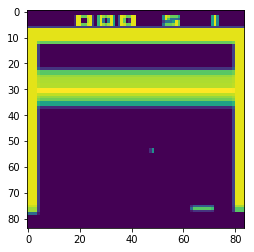

In [2]:
GAME_NAME = "Breakout"
#Due to Keras structuring the data is layout as GameName/Screen/Pixels/All_Images.pngs
IMAGE_LOAD_PATH = f"GameplayData/{GAME_NAME}/Screen"

# Get the files sorted by the order they were modified (created.)

x_mem_train = np.load(f"GameplayData/{GAME_NAME}/Ram/{GAME_NAME}_RAMs.npy")[0:1]
print("The memory has shape:", x_mem_train.shape)

file_names = sorted(glob.glob(f"{IMAGE_LOAD_PATH}/Pixels/*.png"), key=os.path.getmtime)[0:4000]
x_train = np.array([cv2.imread(file) for file in file_names])
x_train = np.array([cv2.cvtColor(image, cv2.COLOR_BGR2RGB) for image in x_train])


# Deepmind DownSampling
x_train = np.array([cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) for image in x_train])
x_train = np.array([cv2.resize(image, (84, 84), interpolation=cv2.INTER_AREA) for image in x_train])
x_train = x_train.reshape(len(x_train), 84, 84, 1)
print("The data has been loaded, with the shape:", x_train.shape)

random.choice(x_train)
random_image = x_train[0]
IMAGE_SHAPE = np.array(random_image).shape
print("Loaded image has shape:",IMAGE_SHAPE )
plt.imshow(random_image.squeeze())


In [3]:
def conv(input_tensor, scope, *, n_filters, filter_size, stride,
         pad='VALID', init_scale=1.0, data_format='NHWC', one_dim_bias=False):
    """
    Creates a 2d convolutional layer for TensorFlow

    :param input_tensor: (TensorFlow Tensor) The input tensor for the convolution
    :param scope: (str) The TensorFlow variable scope
    :param n_filters: (int) The number of filters
    :param filter_size: (int) The filter size
    :param stride: (int) The stride of the convolution
    :param pad: (str) The padding type ('VALID' or 'SAME')
    :param init_scale: (int) The initialization scale
    :param data_format: (str) The data format for the convolution weights
    :param one_dim_bias: (bool) If the bias should be one dimentional or not
    :return: (TensorFlow Tensor) 2d convolutional layer
    """
    if data_format == 'NHWC':
        channel_ax = 3
        strides = [1, stride, stride, 1]
        bshape = [1, 1, 1, n_filters]
    elif data_format == 'NCHW':
        channel_ax = 1
        strides = [1, 1, stride, stride]
        bshape = [1, n_filters, 1, 1]
    else:
        raise NotImplementedError
    bias_var_shape = [n_filters] if one_dim_bias else [1, n_filters, 1, 1]
    n_input = input_tensor.get_shape()[channel_ax].value
    wshape = [filter_size, filter_size, n_input, n_filters]
    with tf.variable_scope(scope):
        weight = tf.get_variable("w", wshape, initializer=ortho_init(init_scale))
        bias = tf.get_variable("b", bias_var_shape, initializer=tf.constant_initializer(0.0))
        if not one_dim_bias and data_format == 'NHWC':
            bias = tf.reshape(bias, bshape)
        return bias + tf.nn.conv2d(input_tensor, weight, strides=strides, padding=pad, data_format=data_format)


def linear(input_tensor, scope, n_hidden, *, init_scale=1.0, init_bias=0.0):
    """
    Creates a fully connected layer for TensorFlow

    :param input_tensor: (TensorFlow Tensor) The input tensor for the fully connected layer
    :param scope: (str) The TensorFlow variable scope
    :param n_hidden: (int) The number of hidden neurons
    :param init_scale: (int) The initialization scale
    :param init_bias: (int) The initialization offset bias
    :return: (TensorFlow Tensor) fully connected layer
    """
    with tf.variable_scope(scope):
        n_input = input_tensor.get_shape()[1].value
        weight = tf.get_variable("w", [n_input, n_hidden], initializer=ortho_init(init_scale))
        bias = tf.get_variable("b", [n_hidden], initializer=tf.constant_initializer(init_bias))
        return tf.matmul(input_tensor, weight) + bias
    
def conv_to_fc(input_tensor):
    """
    Reshapes a Tensor from a convolutional network to a Tensor for a fully connected network

    :param input_tensor: (TensorFlow Tensor) The convolutional input tensor
    :return: (TensorFlow Tensor) The fully connected output tensor
    """
    n_hidden = np.prod([v.value for v in input_tensor.get_shape()[1:]])
    input_tensor = tf.reshape(input_tensor, [-1, n_hidden])
    return input_tensor

def ortho_init(scale=1.0):
    """
    Orthogonal initialization for the policy weights

    :param scale: (float) Scaling factor for the weights.
    :return: (function) an initialization function for the weights
    """

    # _ortho_init(shape, dtype, partition_info=None)
    def _ortho_init(shape, *_, **_kwargs):
        """Intialize weights as Orthogonal matrix.

        Orthogonal matrix initialization [1]_. For n-dimensional shapes where
        n > 2, the n-1 trailing axes are flattened. For convolutional layers, this
        corresponds to the fan-in, so this makes the initialization usable for
        both dense and convolutional layers.

        References
        ----------
        .. [1] Saxe, Andrew M., James L. McClelland, and Surya Ganguli.
               "Exact solutions to the nonlinear dynamics of learning in deep
               linear
        """
        # lasagne ortho init for tf
        shape = tuple(shape)
        if len(shape) == 2:
            flat_shape = shape
        elif len(shape) == 4:  # assumes NHWC
            flat_shape = (np.prod(shape[:-1]), shape[-1])
        else:
            raise NotImplementedError
        gaussian_noise = np.random.normal(0.0, 1.0, flat_shape)
        u, _, v = np.linalg.svd(gaussian_noise, full_matrices=False)
        weights = u if u.shape == flat_shape else v  # pick the one with the correct shape
        weights = weights.reshape(shape)
        return (scale * weights[:shape[0], :shape[1]]).astype(np.float32)

    return _ortho_init

In [4]:
if not ran_once:
    ran_once = True
    x_train = x_train * (1./255)
    x_len = x_train.shape[0]
    print(x_train[ :x_len - 4].shape)
    print(x_train[1:x_len - 3].shape)
    print(x_train[2:x_len - 2].shape)
    print(x_train[3:x_len - 1].shape)

    four_vec_stack = [x_train[ :x_len-4].squeeze(), 
                      x_train[1:x_len-3].squeeze(), 
                      x_train[2:x_len-2].squeeze(),
                      x_train[3:x_len-1].squeeze()]
    # del x_train

    del x_train
    four_vec_stack = np.stack(four_vec_stack, axis=-1)

print(four_vec_stack.shape)

(3996, 84, 84, 1)
(3996, 84, 84, 1)
(3996, 84, 84, 1)
(3996, 84, 84, 1)
(3996, 84, 84, 4)


In [13]:
tf.reset_default_graph()
activ = tf.nn.tanh
obs = tf.placeholder(shape=(None, 84, 84, 4), dtype=tf.float32, name="input")
layer_1 = activ(conv(obs, 'c1', n_filters=32, filter_size=8, stride=4, init_scale=np.sqrt(2)))
layer_2 = activ(conv(layer_1, 'c2', n_filters=64, filter_size=4, stride=2, init_scale=np.sqrt(2)))
layer_3 = activ(conv(layer_2, 'c3', n_filters=64, filter_size=3, stride=1, init_scale=np.sqrt(2)))
layer_3 = conv_to_fc(layer_3)
bottle_neck = activ(linear(layer_3, 'fc1', n_hidden=512, init_scale=np.sqrt(2)), name="feature_extraction_dense")
reverse_layer_3 = layers.Reshape((8, 8, 8))(bottle_neck)

x = layers.Conv2DTranspose(64, (3, 3), strides=1, activation='relu',)(reverse_layer_3)
x = layers.Conv2DTranspose(64, (4, 4), strides= 2, activation='relu')(x)
x = layers.Conv2DTranspose(1, (8, 8), strides= 4, activation='relu')(x)
decoded = layers.Cropping2D(cropping=(4, 4))(x)

labels = tf.placeholder(shape=(None, 84, 84, 1), dtype=tf.float32, name="labels")

In [14]:
loss = tf.losses.mean_squared_error(labels=labels, predictions=decoded)
train = tf.train.AdamOptimizer(0.001, name="AdamPretrain").minimize(loss)


In [15]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

(3996, 84, 84, 1)


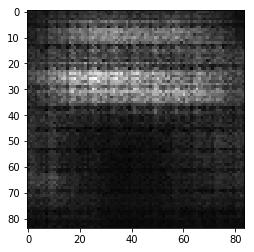

In [17]:
for step in range(10):
    _ = sess.run([train], {obs: four_vec_stack, labels:four_vec_stack[:,:,:,2:3]})
decoded_ = sess.run(decoded, {obs: four_vec_stack, labels:four_vec_stack[:,:,:,2:3]})
print(decoded_.shape)
plt.imshow(decoded_[28].squeeze(), cmap='gray')


In [18]:
from tensorflow.python.saved_model import tag_constants
input_placeholders = {
    "obs": obs,
}
output_tensors = {"bottle_neck": bottle_neck}

tf.saved_model.simple_save(
    sess, 'nature_cnn_output', input_placeholders, output_tensors
)

INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: nature_cnn_output/saved_model.pb


In [12]:
from tensorflow.python.saved_model import tag_constants
restored_graph = tf.Graph()
with restored_graph.as_default():
    with tf.Session() as sess2:
        tf.saved_model.loader.load(
                sess,
                [tag_constants.SERVING],
                'nature_cnn_output',
            )   
        print([n.name for n in tf.get_default_graph().as_graph_def().node])        


INFO:tensorflow:Restoring parameters from nature_cnn_output/variables/variables
[]
